In [ ]:
# SEAS 6414 HW8
# This homework focuses on analyzing and forecasting merchant transaction data using
# various time series techniques. The primary objective is to apply different forecasting
# models and evaluate their performance in predicting future transaction volumes.


In [6]:
cd C:\\Users\\1126692\\Desktop\\Desktop Files\\Papers\\GWU PhD\\Python Lectures\\Lecture8

C:\Users\1126692\Desktop\Desktop Files\Papers\GWU PhD\Python Lectures\Lecture8


In [7]:
pwd

'C:\\Users\\1126692\\Desktop\\Desktop Files\\Papers\\GWU PhD\\Python Lectures\\Lecture8'

In [135]:
import matplotlib.pyplot as plt  # plots
import numpy as np  # vectors and matrices
import pandas as pd  # tables and data manipulations
import seaborn as sns  # more plots

sns.set()

import warnings  
from itertools import product  # some useful functions

import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.formula.api as smf  # statistics and econometrics
import statsmodels.tsa.api as smt
from dateutil.relativedelta import \
    relativedelta  # working with dates with style
from scipy.optimize import minimize  # for function minimization
from tqdm.notebook import tqdm

warnings.filterwarnings("ignore") # `do not disturbe` mode

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [136]:
# Read the data from CSV
# Sets the "time" column as the index. With parse_dates=True argument ensuring dates are parsed correctly
#df = pd.read_csv("homework8.csv", index_col="time", parse_dates=True)
df = pd.read_csv("homework8.csv", index_col=["time"], parse_dates=["time"])
df.head(10)

# Filter data for the desired period (2033-01-01 to 2035-01-01)
df = df[(df.index >= "2033-01-01") & (df.index < "2035-01-01")]

# Resample data to daily transaction sums
daily_transactions = df.resample("D")["amount_usd_in_cents"].sum()  # Assuming "amount" is your transaction column

# Print the resulting DataFrame (optional)
print(daily_transactions.head())

# Save the resampled data (optional)
daily_transactions.to_csv("daily_transactions.csv")

time
2033-01-01     441540
2033-01-02     475862
2033-01-03     628353
2033-01-04     485111
2033-01-05    1001621
Freq: D, Name: amount_usd_in_cents, dtype: int64


In [138]:
df.head()

,Unnamed: 0,merchant,amount_usd_in_cents
time,,,
2034-06-17 23:34:14,1,faa029c6b0,6349
2034-12-27 00:40:38,2,ed7a7d91aa,3854
2034-04-30 01:29:42,3,5608f200cf,789
2034-09-16 01:06:23,4,15b1a0d61e,4452
2034-07-22 16:21:42,5,4770051790,20203


In [139]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15, 5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")

        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series < lower_bond] = series[series < lower_bond]
            anomalies[series > upper_bond] = series[series > upper_bond]
            plt.plot(anomalies, "ro", markersize=10)

    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

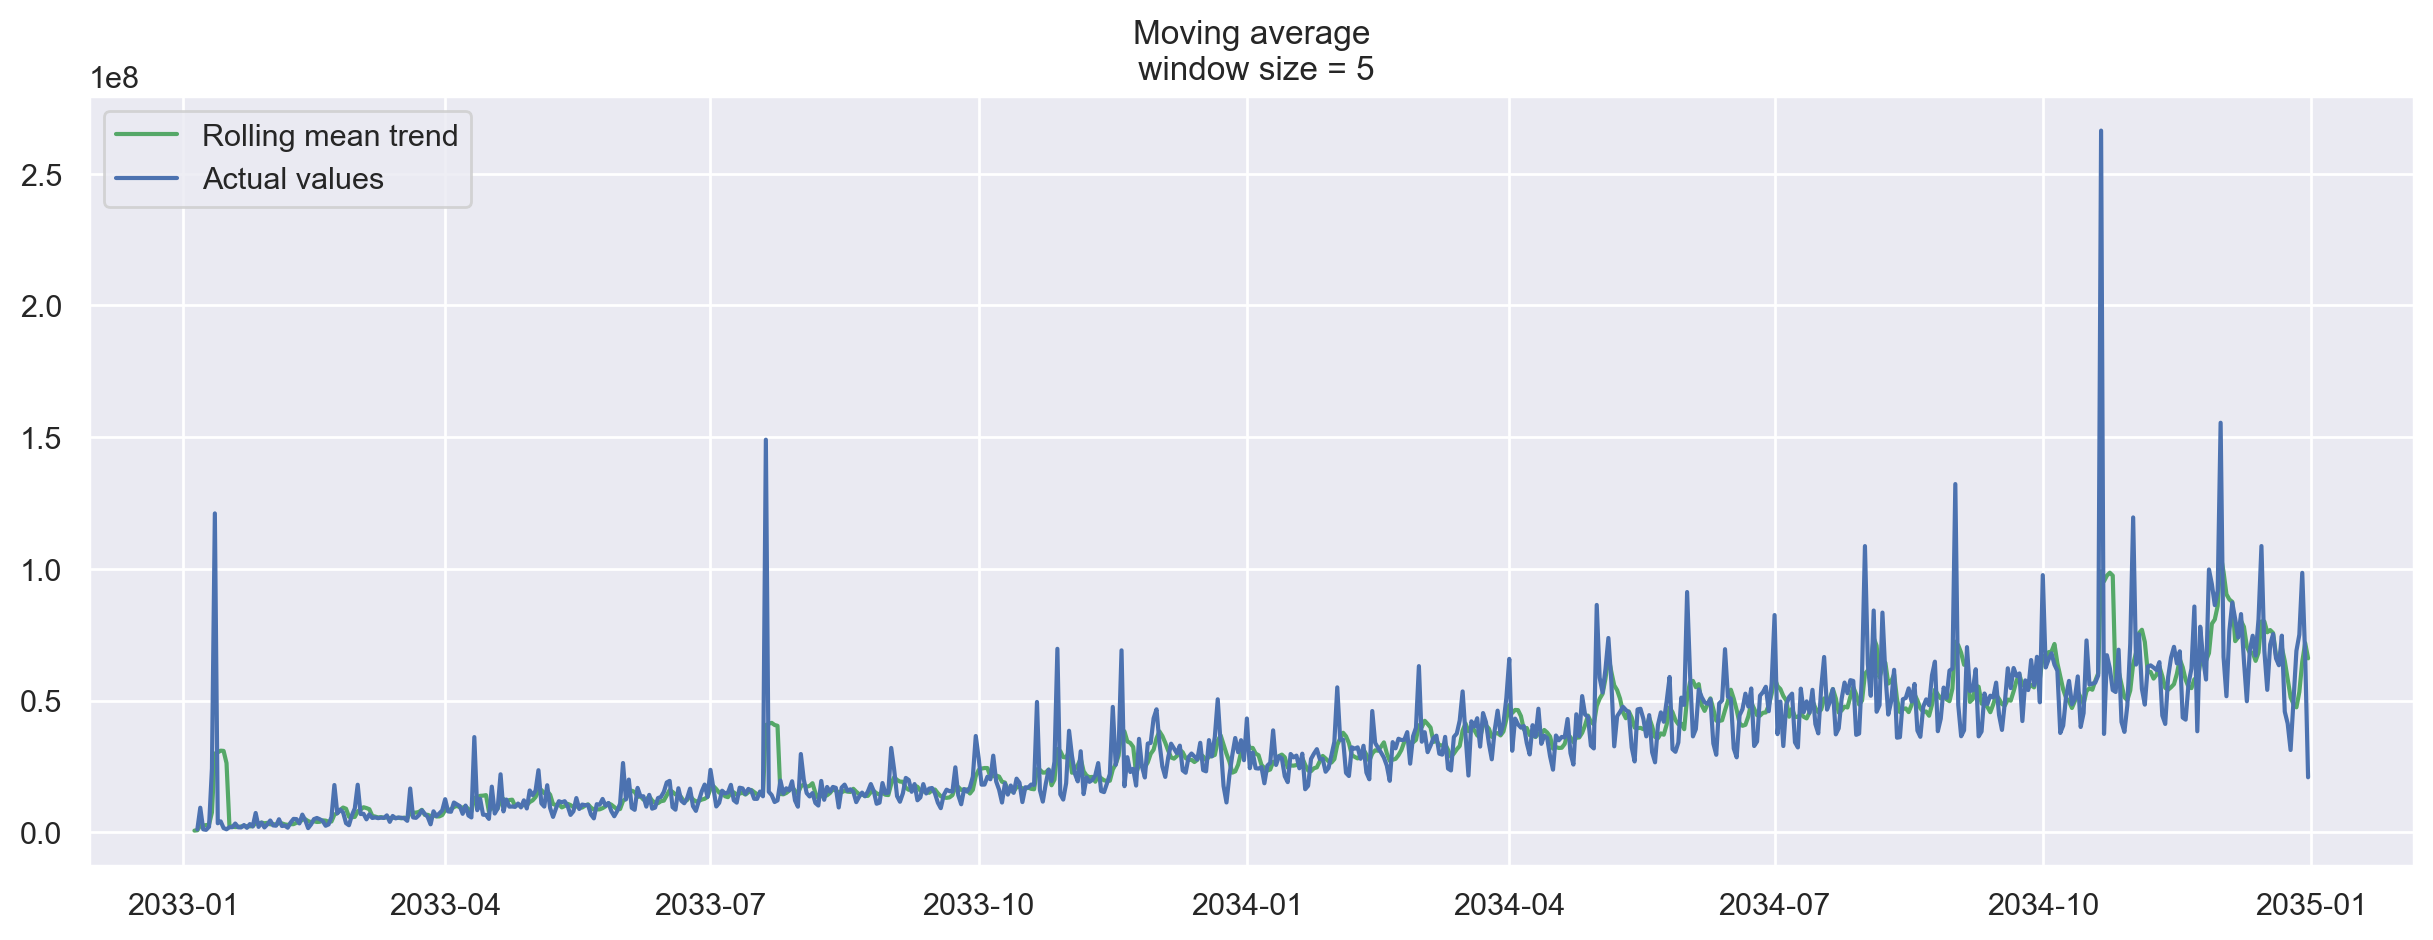

In [140]:
    series = df.resample("D")["amount_usd_in_cents"].sum()
    plotMovingAverage(series, 5)

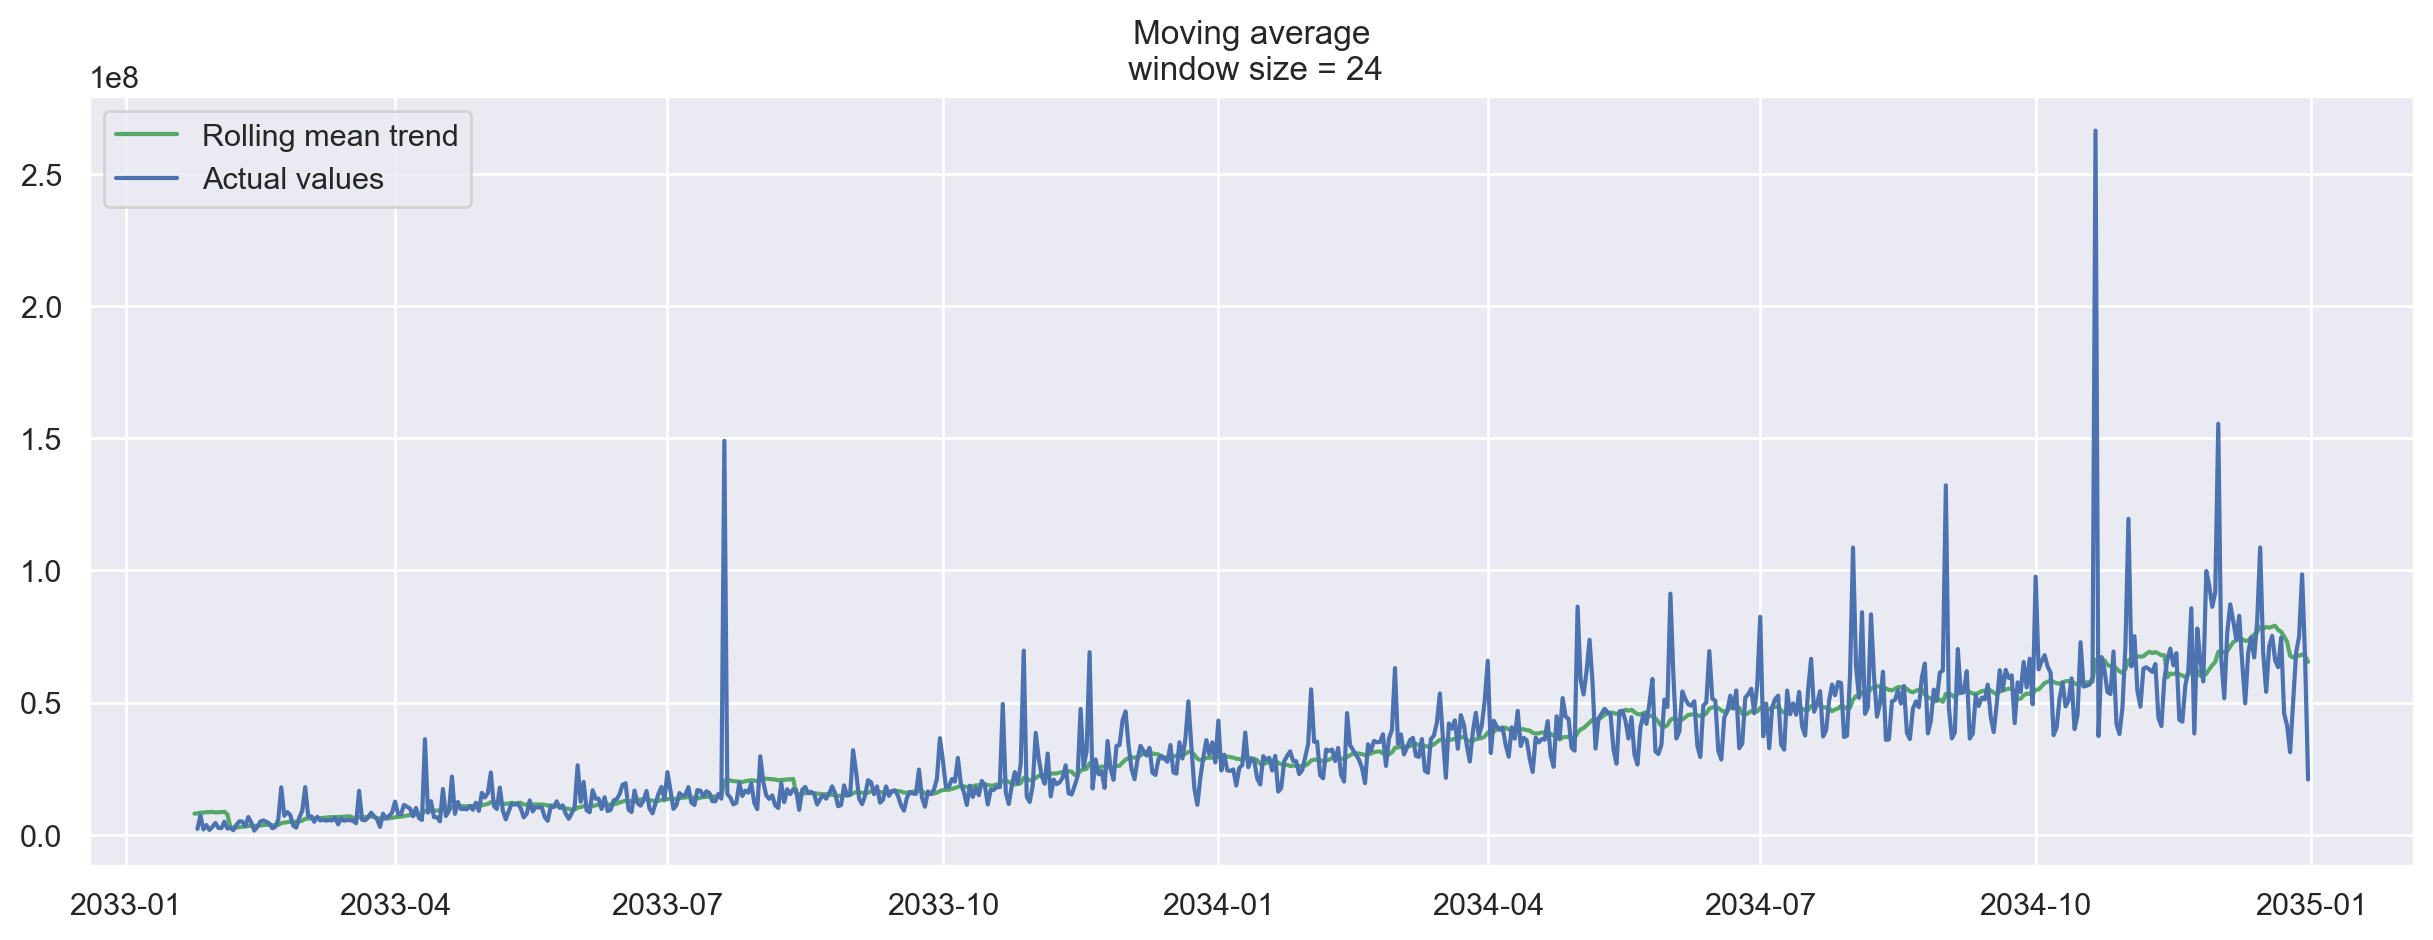

In [141]:
    series = df.resample("D")["amount_usd_in_cents"].sum()
    plotMovingAverage(series, 24)

In [142]:
class HoltWinters:

    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i + self.slen] - self.series[i]) / self.slen
        return sum / self.slen

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series) / self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(
                sum(self.series[self.slen * j : self.slen * j + self.slen])
                / float(self.slen)
            )
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += (
                    self.series[self.slen * j + i] - season_averages[j]
                )
            seasonals[i] = sum_of_vals_over_avg / n_seasons
        return seasonals

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series) + self.n_preds):
            if i == 0:  # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i % self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(
                    self.result[0] + self.scaling_factor * self.PredictedDeviation[0]
                )

                self.LowerBond.append(
                    self.result[0] - self.scaling_factor * self.PredictedDeviation[0]
                )
                continue

            if i >= len(self.series):  # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m * trend) + seasonals[i % self.slen])

                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1] * 1.01)

            else:
                val = self.series[i]
                last_smooth, smooth = (
                    smooth,
                    self.alpha * (val - seasonals[i % self.slen])
                    + (1 - self.alpha) * (smooth + trend),
                )
                trend = self.beta * (smooth - last_smooth) + (1 - self.beta) * trend
                seasonals[i % self.slen] = (
                    self.gamma * (val - smooth)
                    + (1 - self.gamma) * seasonals[i % self.slen]
                )
                self.result.append(smooth + trend + seasonals[i % self.slen])

                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(
                    self.gamma * np.abs(self.series[i] - self.result[i])
                    + (1 - self.gamma) * self.PredictedDeviation[-1]
                )

            self.UpperBond.append(
                self.result[-1] + self.scaling_factor * self.PredictedDeviation[-1]
            )

            self.LowerBond.append(
                self.result[-1] - self.scaling_factor * self.PredictedDeviation[-1]
            )

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

In [110]:
from sklearn.model_selection import \
    TimeSeriesSplit  # you have everything done for you


def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []

    values = series.values
    alpha, beta, gamma = params

    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3)

    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(
            series=values[train],
            slen=slen,
            alpha=alpha,
            beta=beta,
            gamma=gamma,
            n_preds=len(test),
        )
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test) :]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)

    return np.mean(np.array(errors))

In [143]:
%%time
data = series[:-20]  # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0]

# Minimizing the loss function
opt = minimize(
    timeseriesCVscore,
    x0=x,
    args=(data, mean_squared_error),
    method="TNC",
    bounds=((0, 1), (0, 1), (0, 1)),
)

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 50 hours
model = HoltWinters(
    data,
    slen=24,
    alpha=alpha_final,
    beta=beta_final,
    gamma=gamma_final,
    n_preds=50,
    scaling_factor=3,
)
model.triple_exponential_smoothing()


0.008762048299757241 0.026538048837812356 0.08944430594110026
CPU times: total: 3.11 s
Wall time: 3.11 s


In [133]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """

    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label="Model")
    plt.plot(series.values, label="Actual")
    error = mean_absolute_percentage_error(series.values, model.result[: len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))

    if plot_anomalies:
        anomalies = np.array([np.NaN] * len(series))
        anomalies[series.values < model.LowerBond[: len(series)]] = series.values[
            series.values < model.LowerBond[: len(series)]
        ]
        anomalies[series.values > model.UpperBond[: len(series)]] = series.values[
            series.values > model.UpperBond[: len(series)]
        ]
        plt.plot(anomalies, "o", markersize=10, label="Anomalies")

    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label="Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(
            x=range(0, len(model.result)),
            y1=model.UpperBond,
            y2=model.LowerBond,
            alpha=0.2,
            color="grey",
        )

    plt.vlines(
        len(series),
        ymin=min(model.LowerBond),
        ymax=max(model.UpperBond),
        linestyles="dashed",
    )
    plt.axvspan(len(series) - 20, len(model.result), alpha=0.3, color="lightgrey")
    plt.grid(True)
    plt.axis("tight")
    plt.legend(loc="best", fontsize=13);

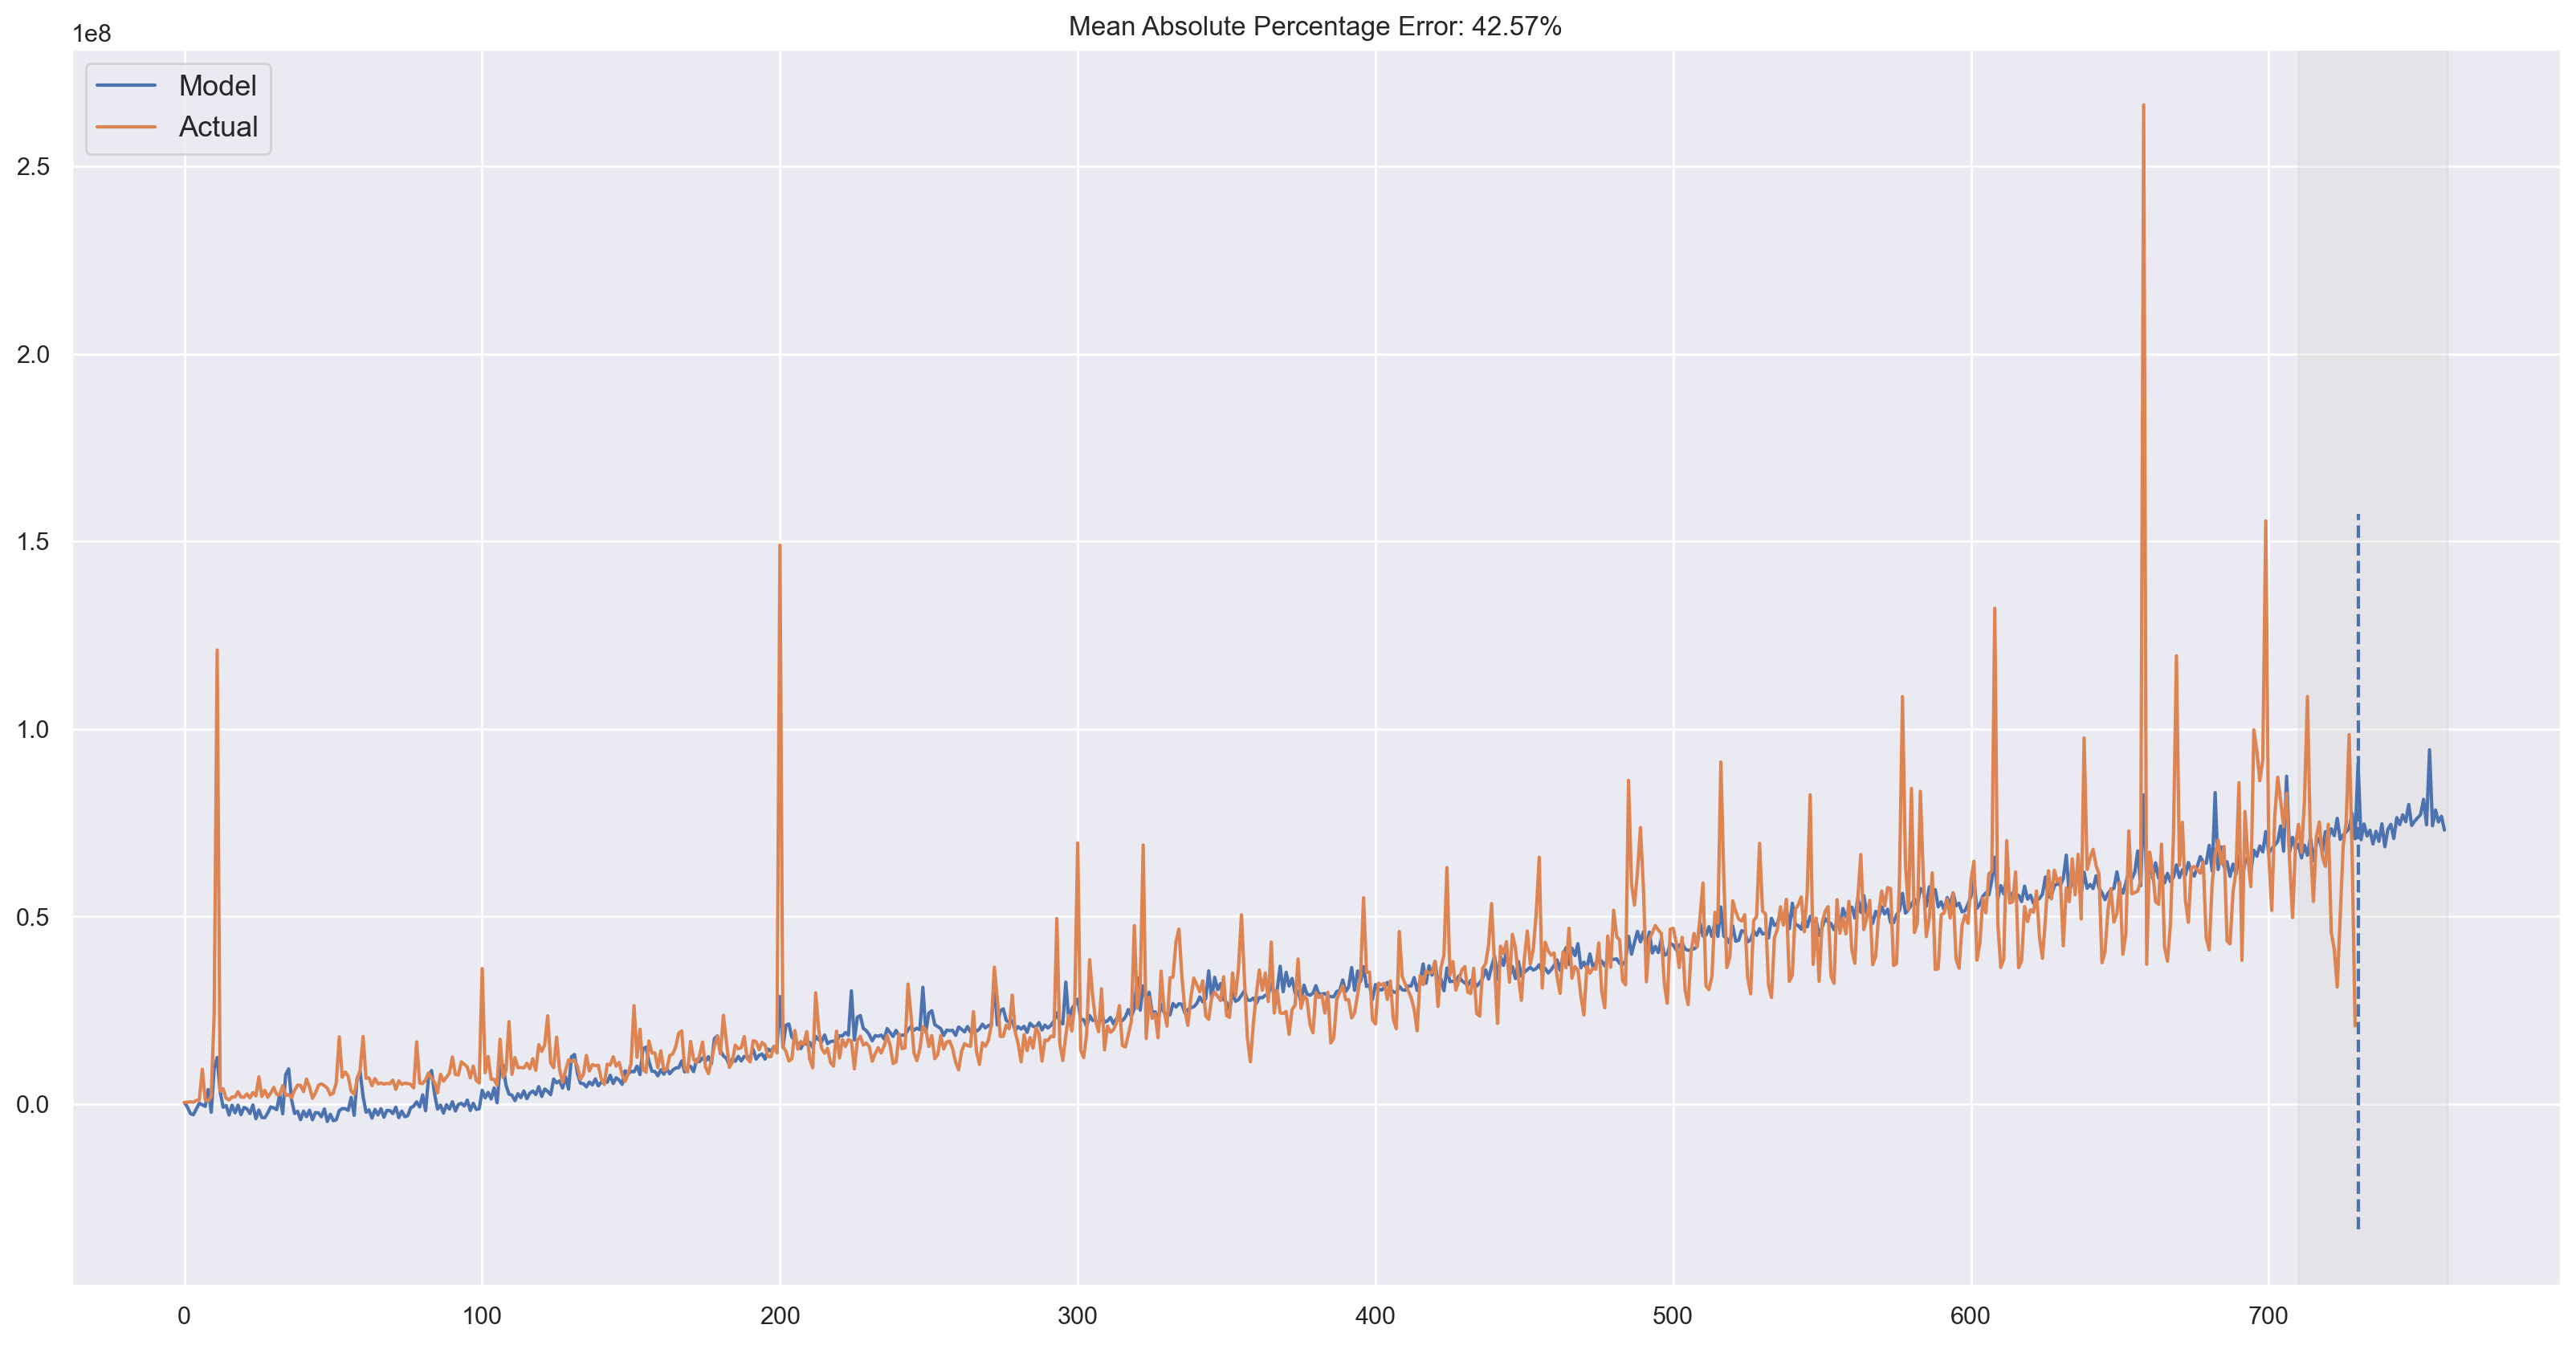

In [114]:
plotHoltWinters(series)

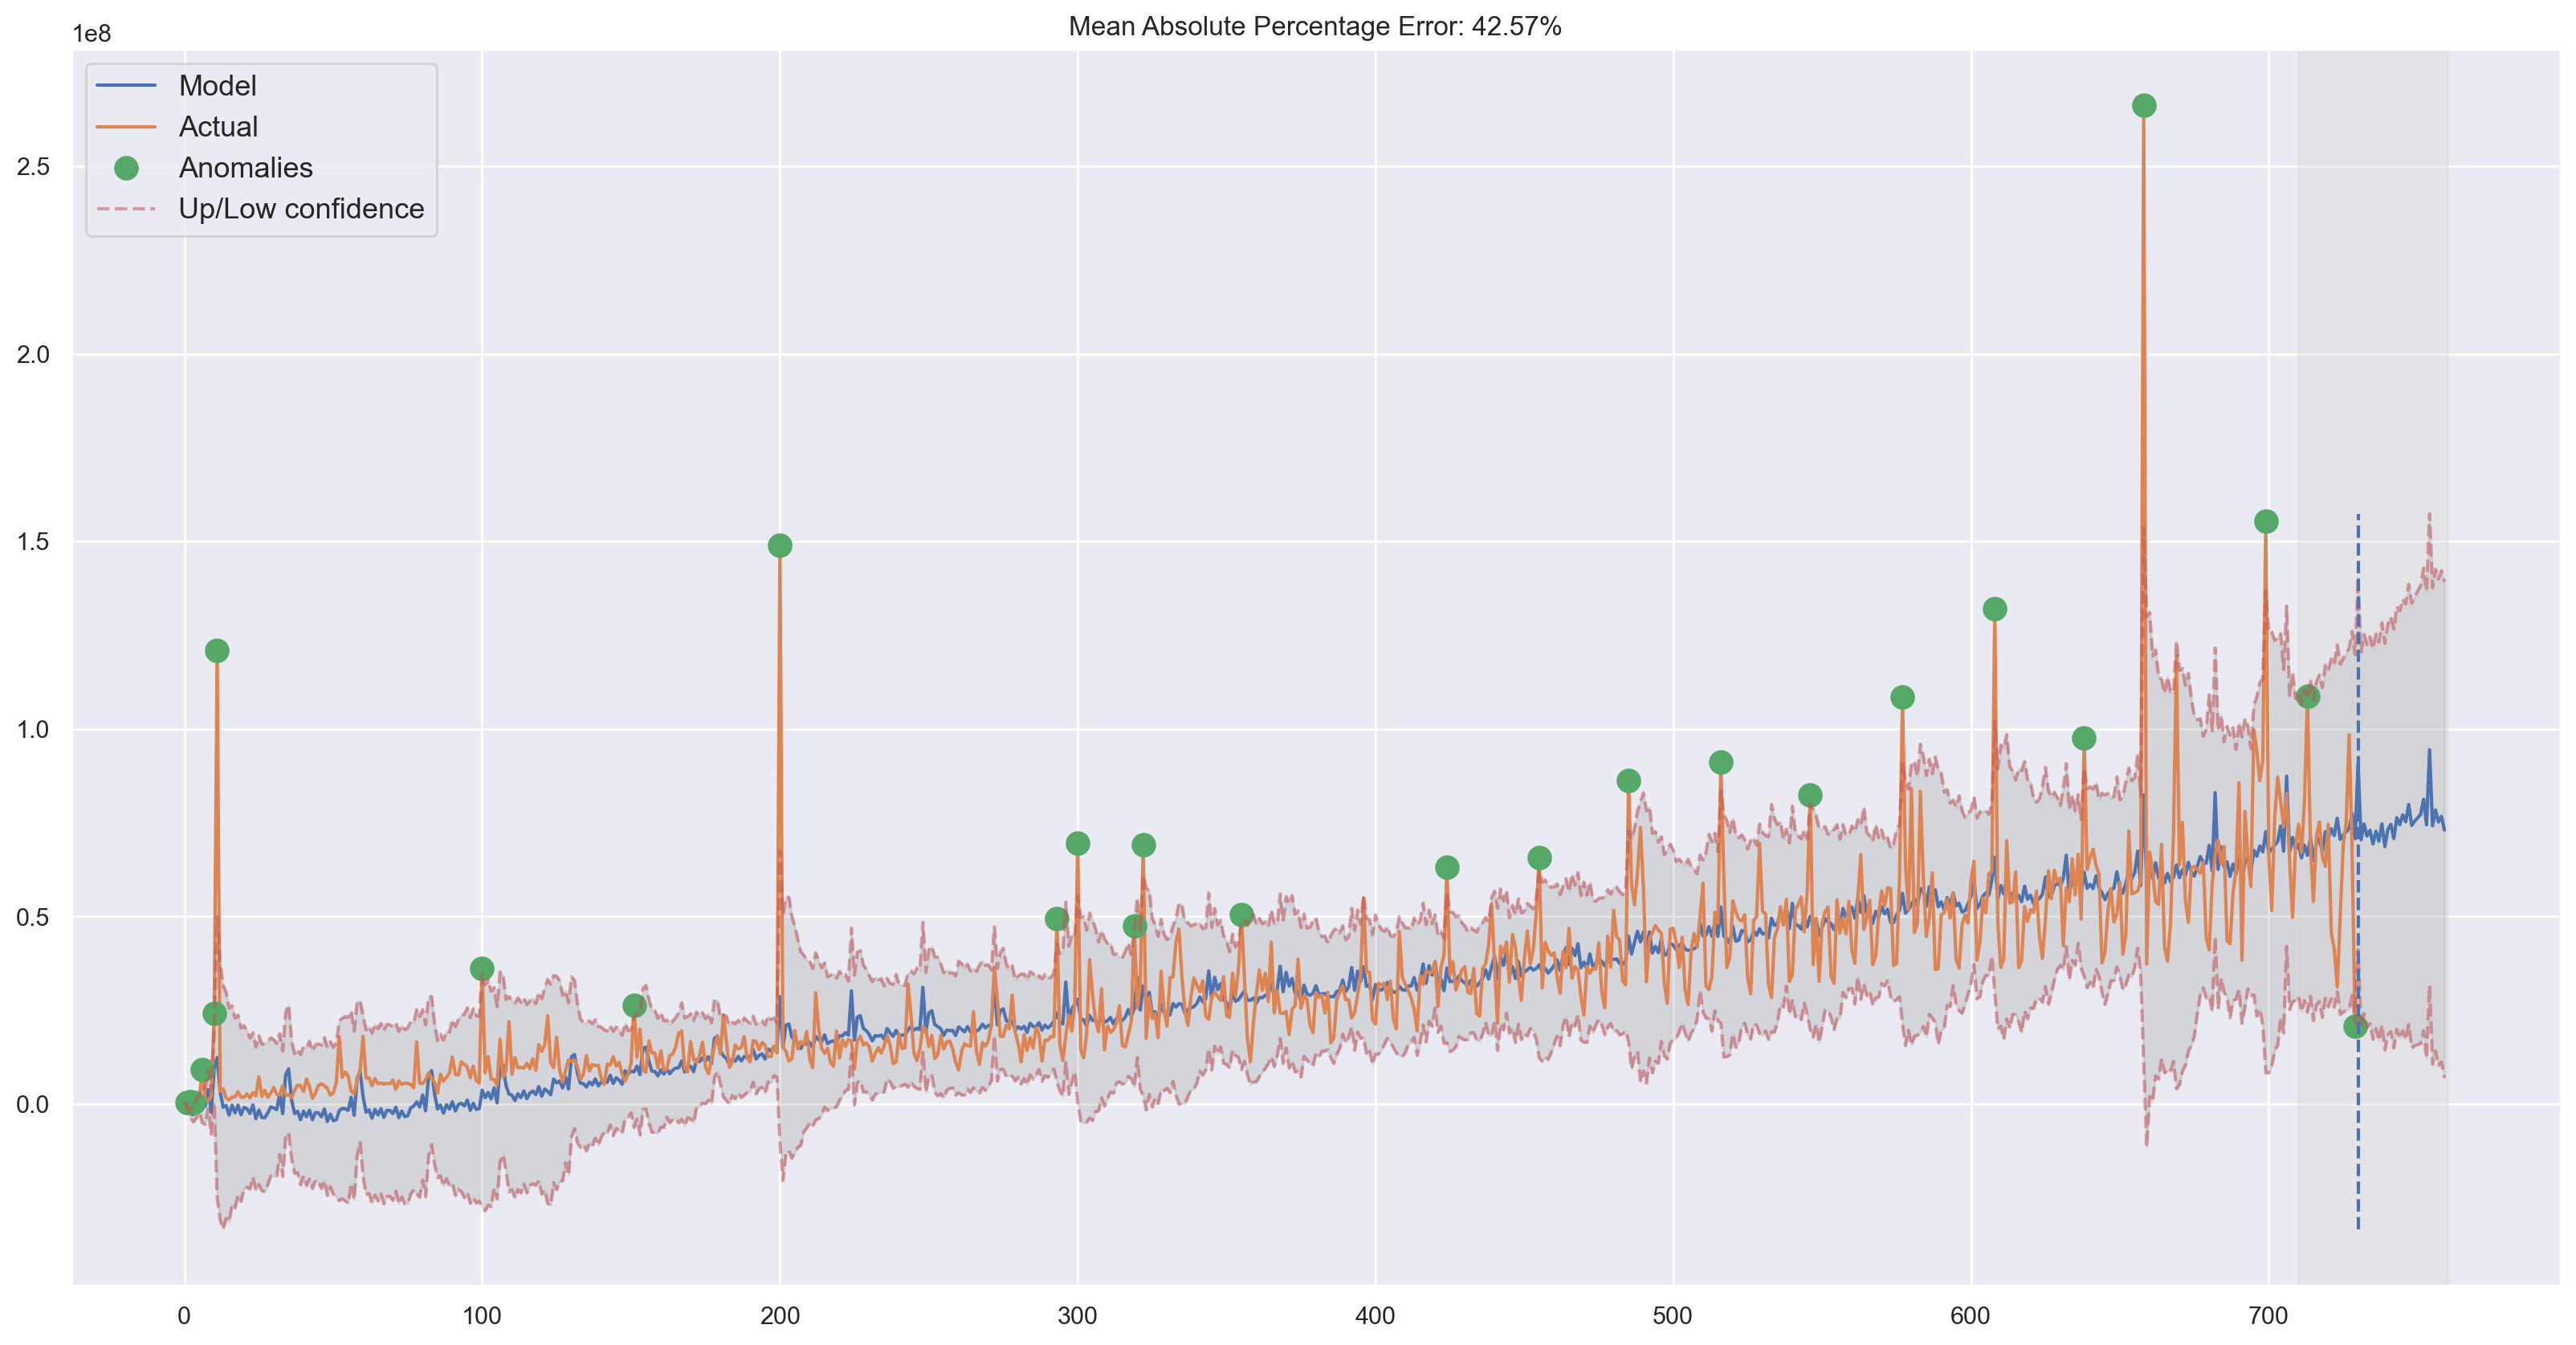

In [144]:
plotHoltWinters(series, plot_intervals=True, plot_anomalies=True)

In [173]:
# Time Series Lags
# Creating a copy of the initial datagrame to make various transformations
data = pd.DataFrame(series.copy())
data.columns = ["y"]

In [174]:
# Adding the lag of the target variable from 6 steps back up to 24
for i in range(6, 25):
    data["lag_{}".format(i)] = data.y.shift(i)

In [175]:
# take a look at the new dataframe
data.tail(5)

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
time,,,,,,,,,,,,,,,,,,,,
2034-12-27,68857347,63382061.0,65989145.0,75217123.0,71284249.0,54035950.0,68896540.0,108637585.0,80841672.0,67071573.0,74589688.0,68882995.0,49712773.0,64972558.0,82809279.0,73969685.0,80903937.0,87144925.0,76417363.0,51624461.0
2034-12-28,75002080,74618326.0,63382061.0,65989145.0,75217123.0,71284249.0,54035950.0,68896540.0,108637585.0,80841672.0,67071573.0,74589688.0,68882995.0,49712773.0,64972558.0,82809279.0,73969685.0,80903937.0,87144925.0,76417363.0
2034-12-29,98467208,45794273.0,74618326.0,63382061.0,65989145.0,75217123.0,71284249.0,54035950.0,68896540.0,108637585.0,80841672.0,67071573.0,74589688.0,68882995.0,49712773.0,64972558.0,82809279.0,73969685.0,80903937.0,87144925.0
2034-12-30,66855995,41262969.0,45794273.0,74618326.0,63382061.0,65989145.0,75217123.0,71284249.0,54035950.0,68896540.0,108637585.0,80841672.0,67071573.0,74589688.0,68882995.0,49712773.0,64972558.0,82809279.0,73969685.0,80903937.0
2034-12-31,20853308,31208341.0,41262969.0,45794273.0,74618326.0,63382061.0,65989145.0,75217123.0,71284249.0,54035950.0,68896540.0,108637585.0,80841672.0,67071573.0,74589688.0,68882995.0,49712773.0,64972558.0,82809279.0,73969685.0


In [176]:
# Train New Model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# for time-series cross-validation set 5 folds
tscv = TimeSeriesSplit(n_splits=5)

In [177]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """

    # get the index after which test set starts
    test_index = int(len(X) * (1 - test_size))

    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]

    return X_train, X_test, y_train, y_test

In [178]:
y = data.dropna().y
X = data.dropna().drop(["y"], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [179]:
# machine learning in two lines
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [180]:
def plotModelResults(
    model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False
):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """

    prediction = model.predict(X_test)

    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)

    if plot_intervals:
        cv = cross_val_score(
            model, X_train, y_train, cv=tscv, scoring="neg_mean_absolute_error"
        )
        mae = cv.mean() * (-1)
        deviation = cv.std()

        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)

        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)

        if plot_anomalies:
            anomalies = np.array([np.NaN] * len(y_test))
            anomalies[y_test < lower] = y_test[y_test < lower]
            anomalies[y_test > upper] = y_test[y_test > upper]
            plt.plot(anomalies, "o", markersize=10, label="Anomalies")

    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)


def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """

    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)

    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind="bar")
    plt.grid(True, axis="y")
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles="dashed");

In [151]:
# 2.4 Linear Regression Model
# Implement a linear regression model using the lagged features.
# create lagged features for linear regression and random forest models
# and implement the linear regression model using these features:

import pandas as pd

# Load your daily_transactions data
data = pd.read_csv('daily_transactions.csv') 

# Define how many lags to create (replace values here)
lag_periods = [1, 7, 30]  # Example for daily, weekly, and monthly lags

# Create lagged features
for lag in lag_periods:
    data[f"transaction_lag_{lag}"] = data["amount_usd_in_cents"].shift(lag)  # Assume 'amount' is your transaction column

# Drop initial rows with missing values (NaN)
data = data.dropna() 

In [181]:
data.head()

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
time,,,,,,,,,,,,,,,,,,,,
2033-01-01,441540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2033-01-02,475862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2033-01-03,628353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2033-01-04,485111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2033-01-05,1001621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


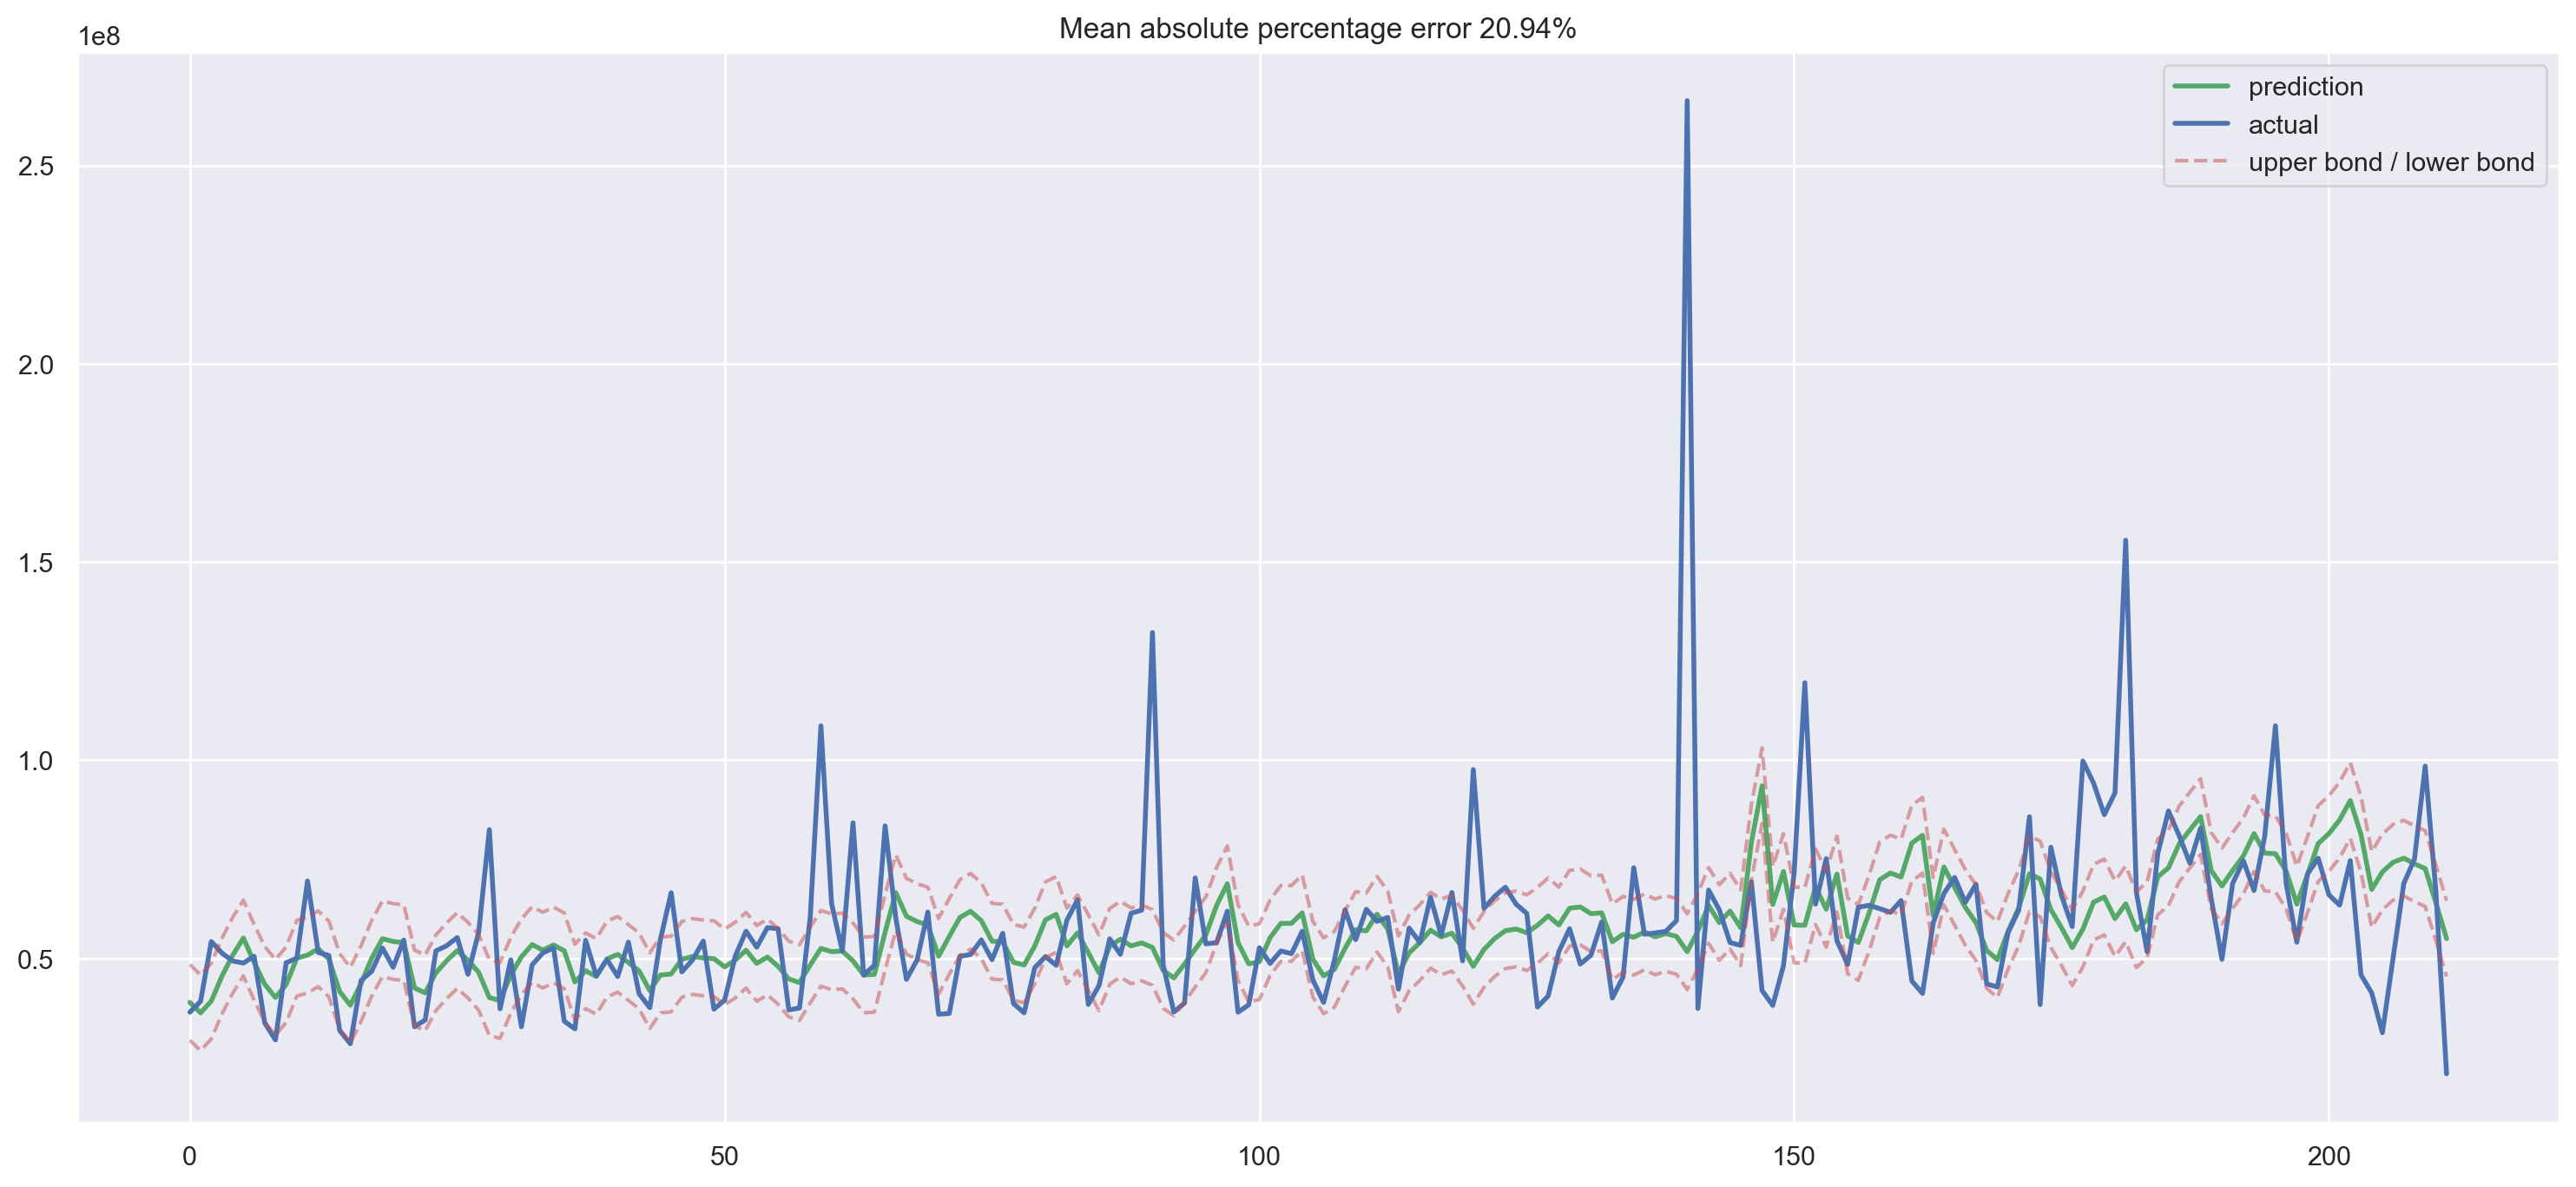

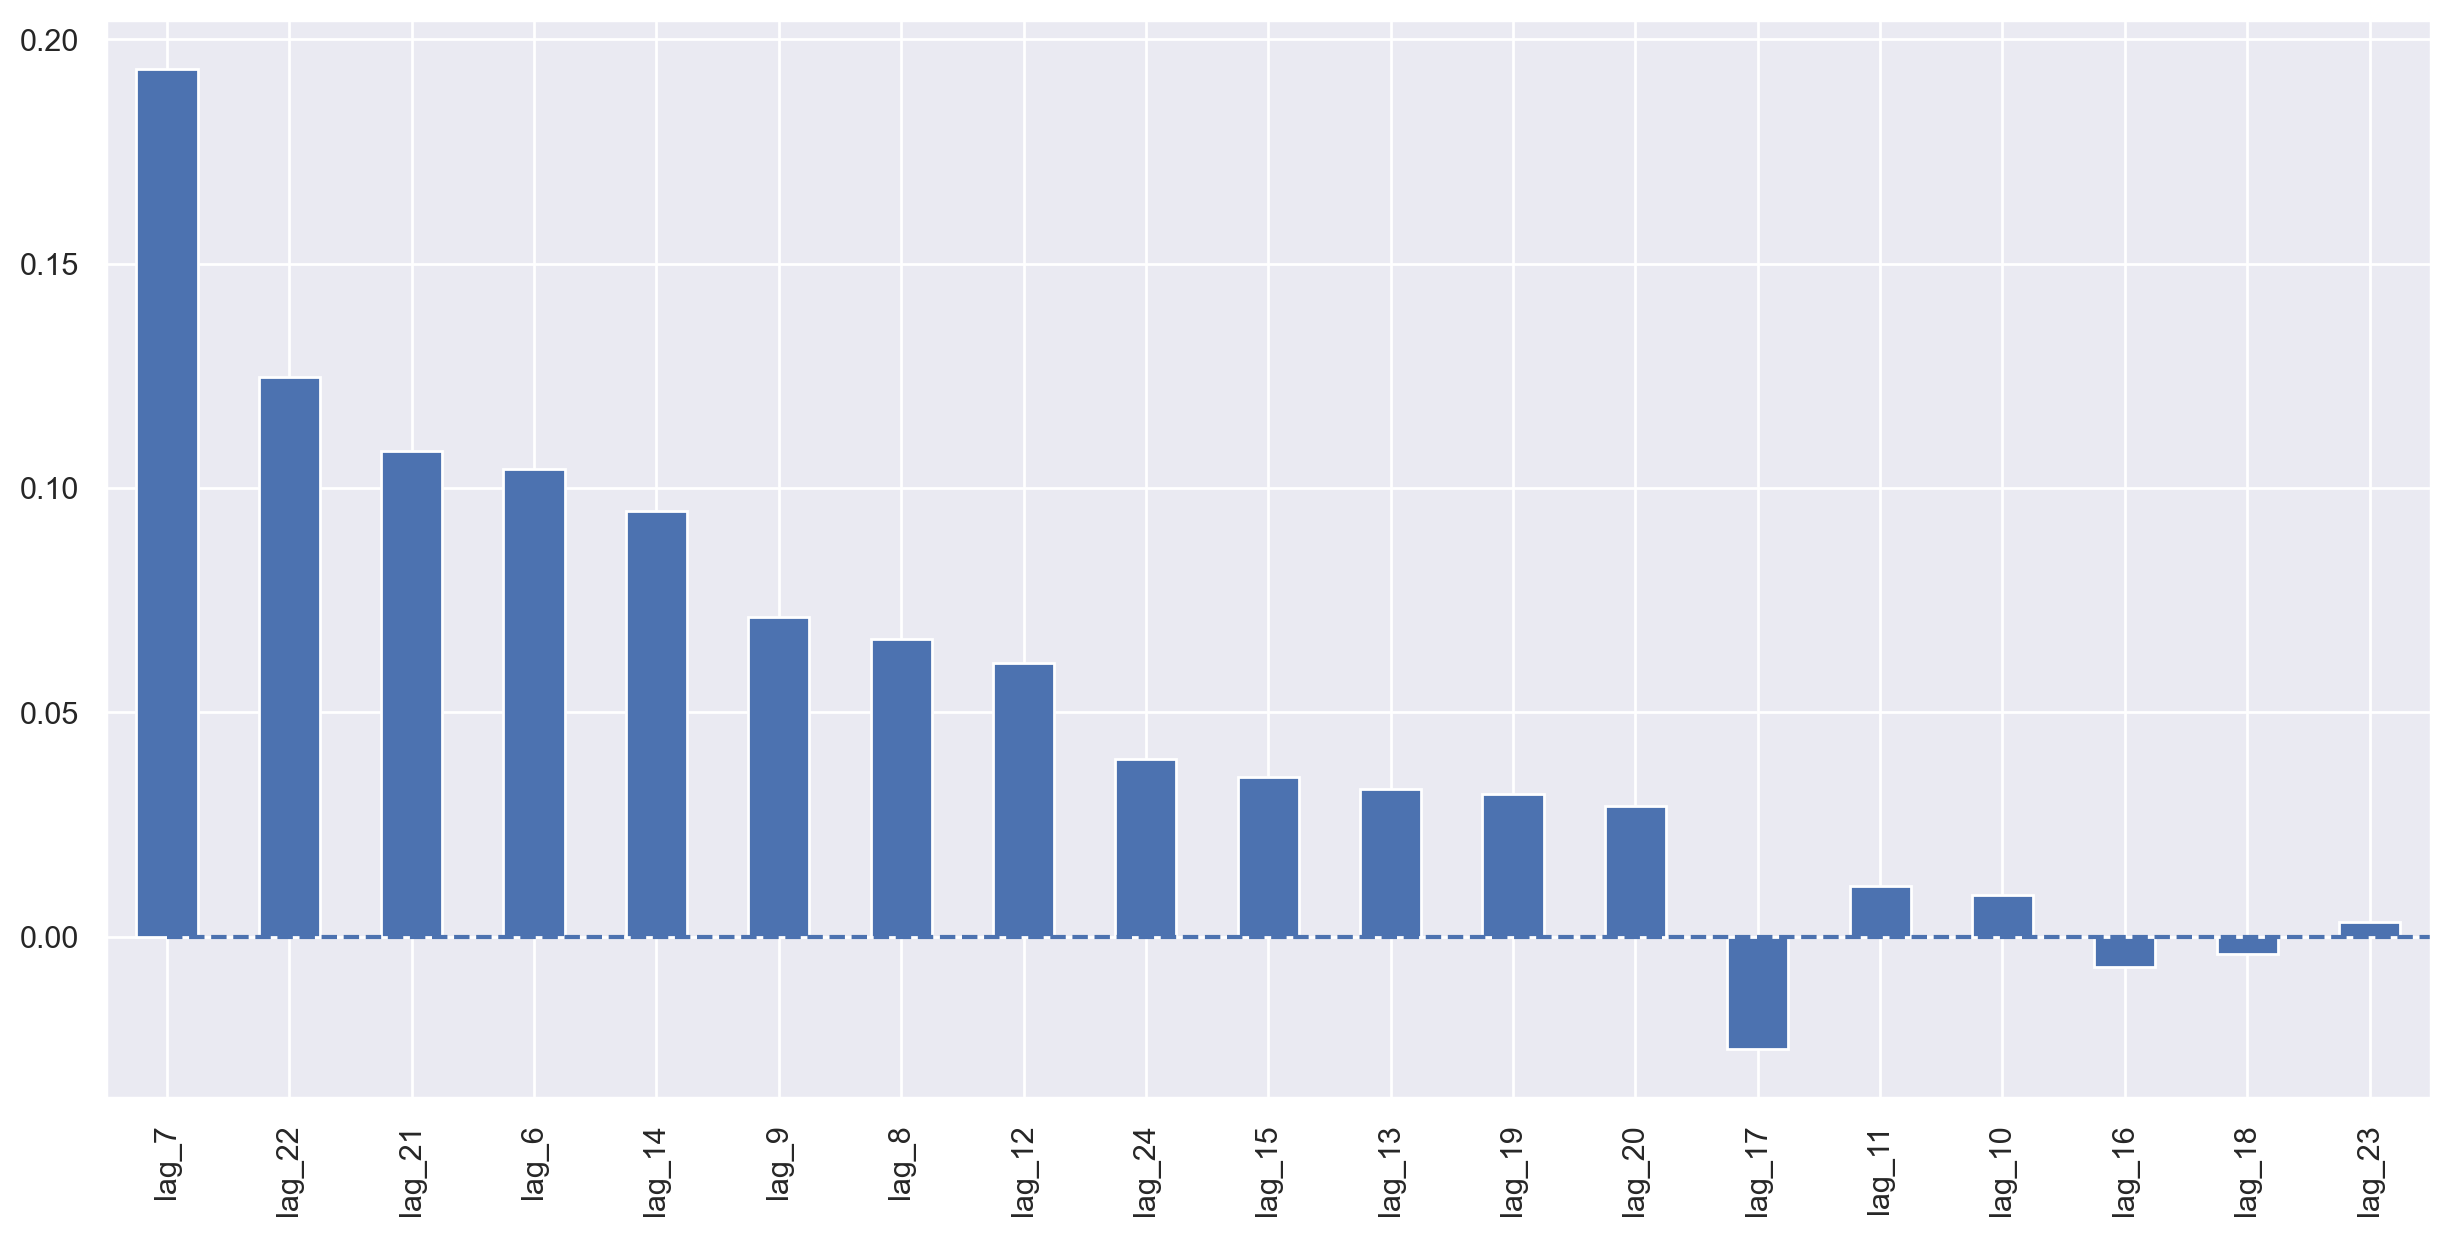

In [182]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

In [183]:
# Scale Feature Data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

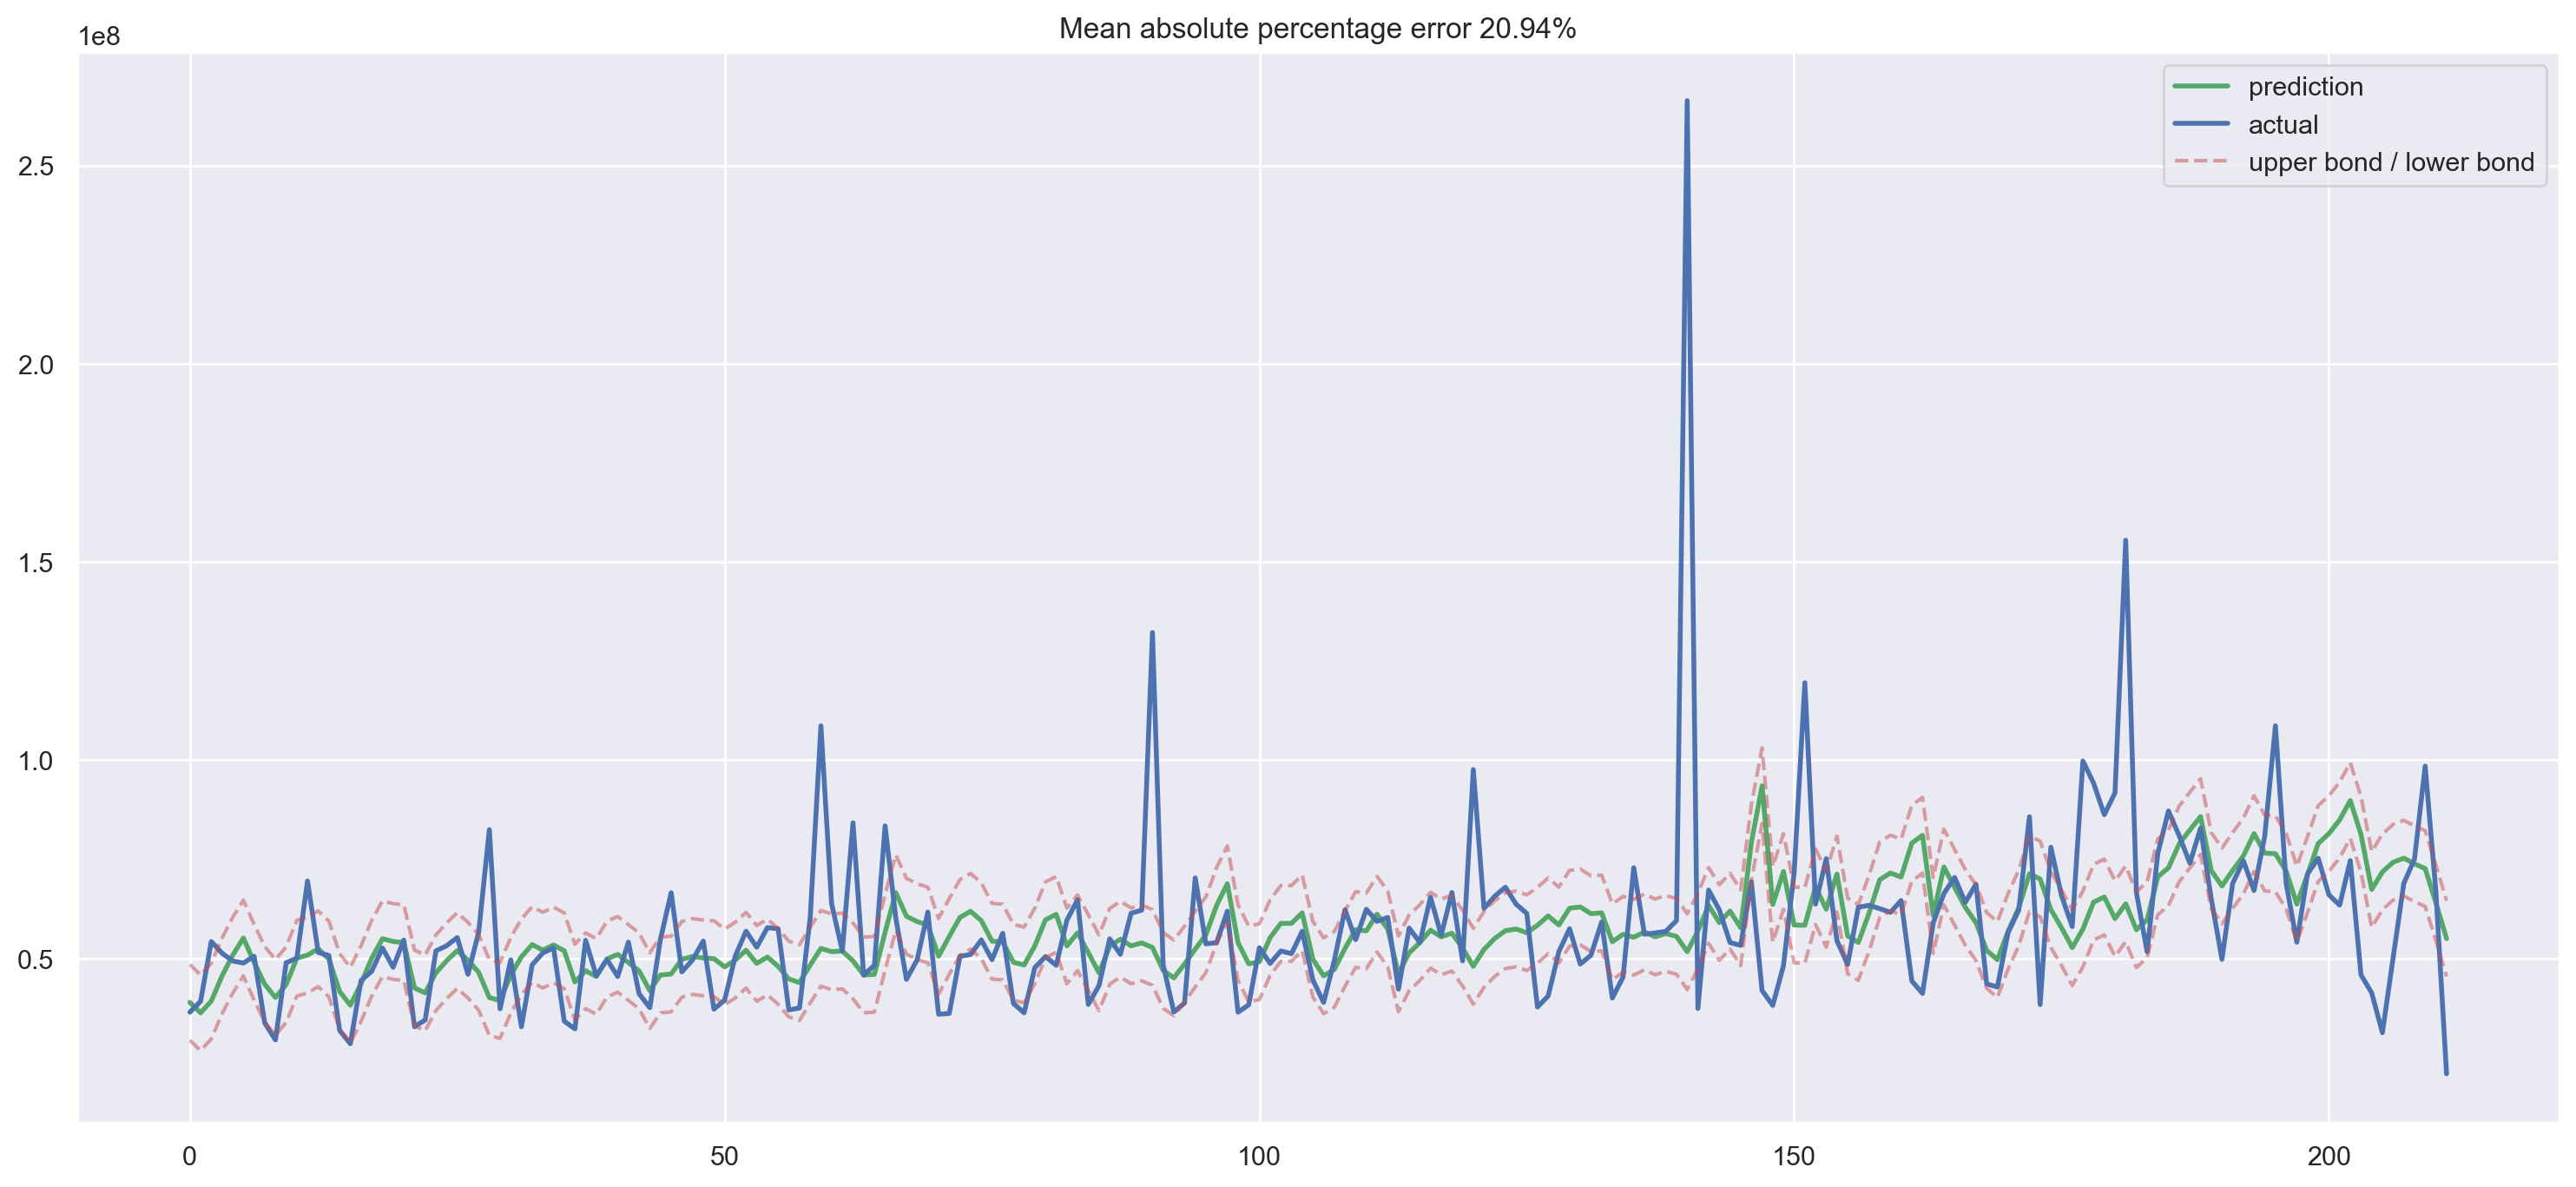

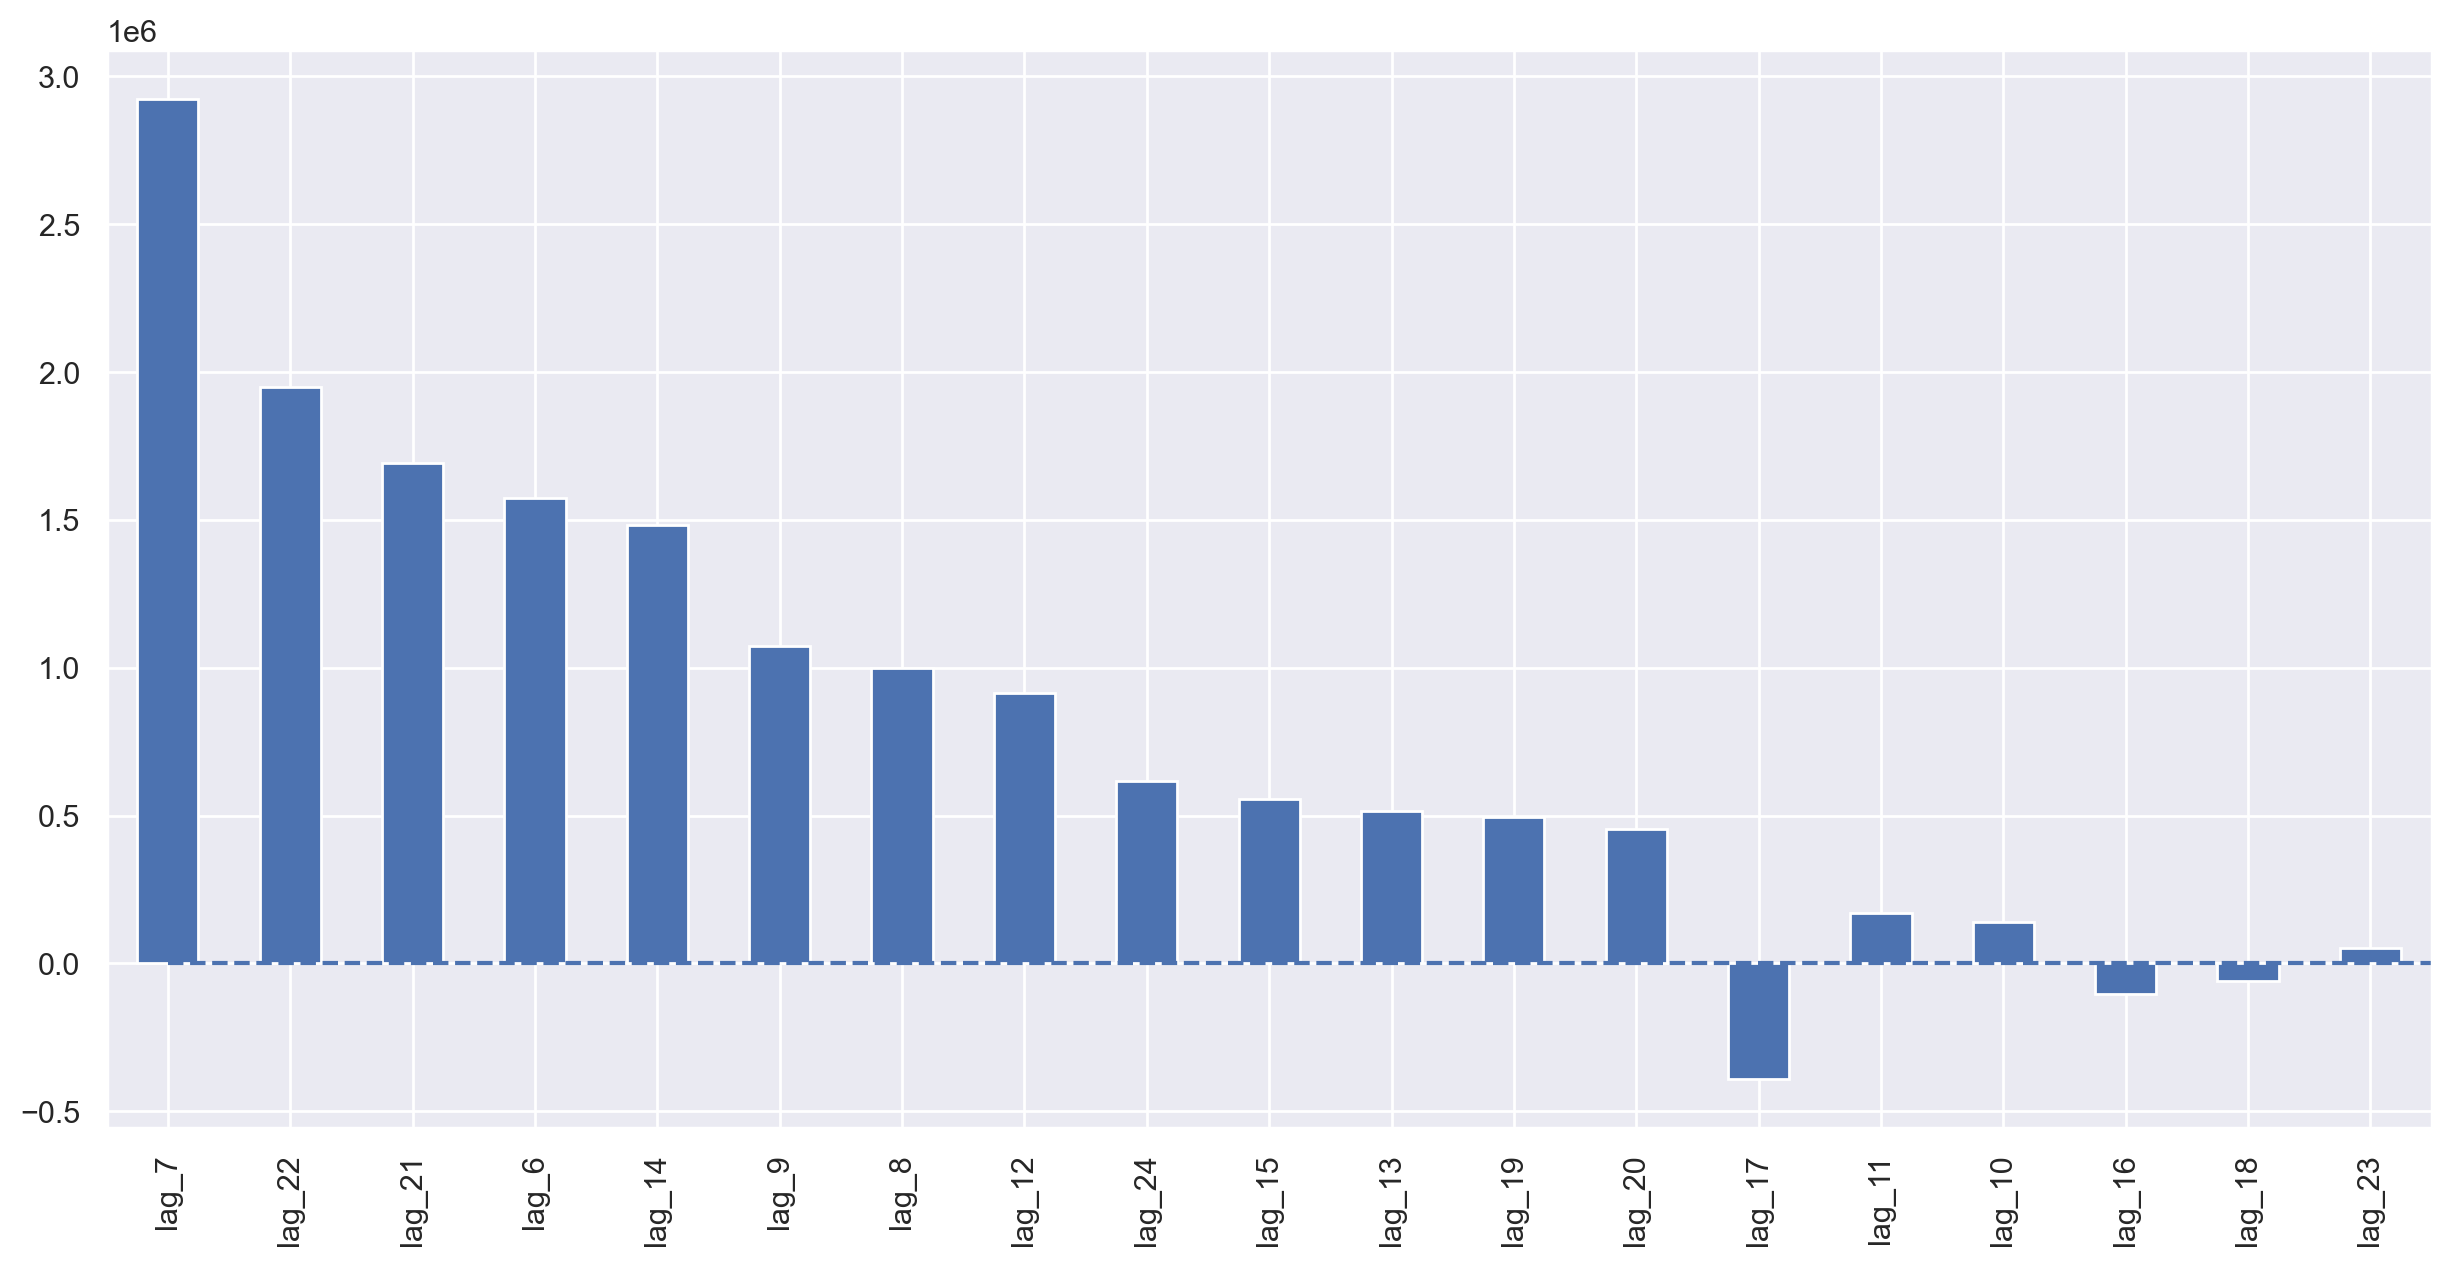

In [184]:
y = data.dropna().y
X = data.dropna().drop(["y"], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

In [185]:
#Target Encoding
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [186]:
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """

    # copy of the initial dataset
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]

    # lags of series
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)

    # datetime features
    data.index = pd.to_datetime(data.index)
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data["is_weekend"] = data.weekday.isin([5, 6]) * 1

    if target_encoding:
        # calculate averages on train set only
        test_index = int(len(data.dropna()) * (1 - test_size))
        data["weekday_average"] = list(
            map(code_mean(data[:test_index], "weekday", "y").get, data.weekday)
        )
        data["hour_average"] = list(
            map(code_mean(data[:test_index], "hour", "y").get, data.hour)
        )

        # drop encoded variables
        data.drop(["hour", "weekday"], axis=1, inplace=True)

    # train-test split
    y = data.dropna().y
    X = data.dropna().drop(["y"], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(
        X, y, test_size=test_size
    )

    return X_train, X_test, y_train, y_test

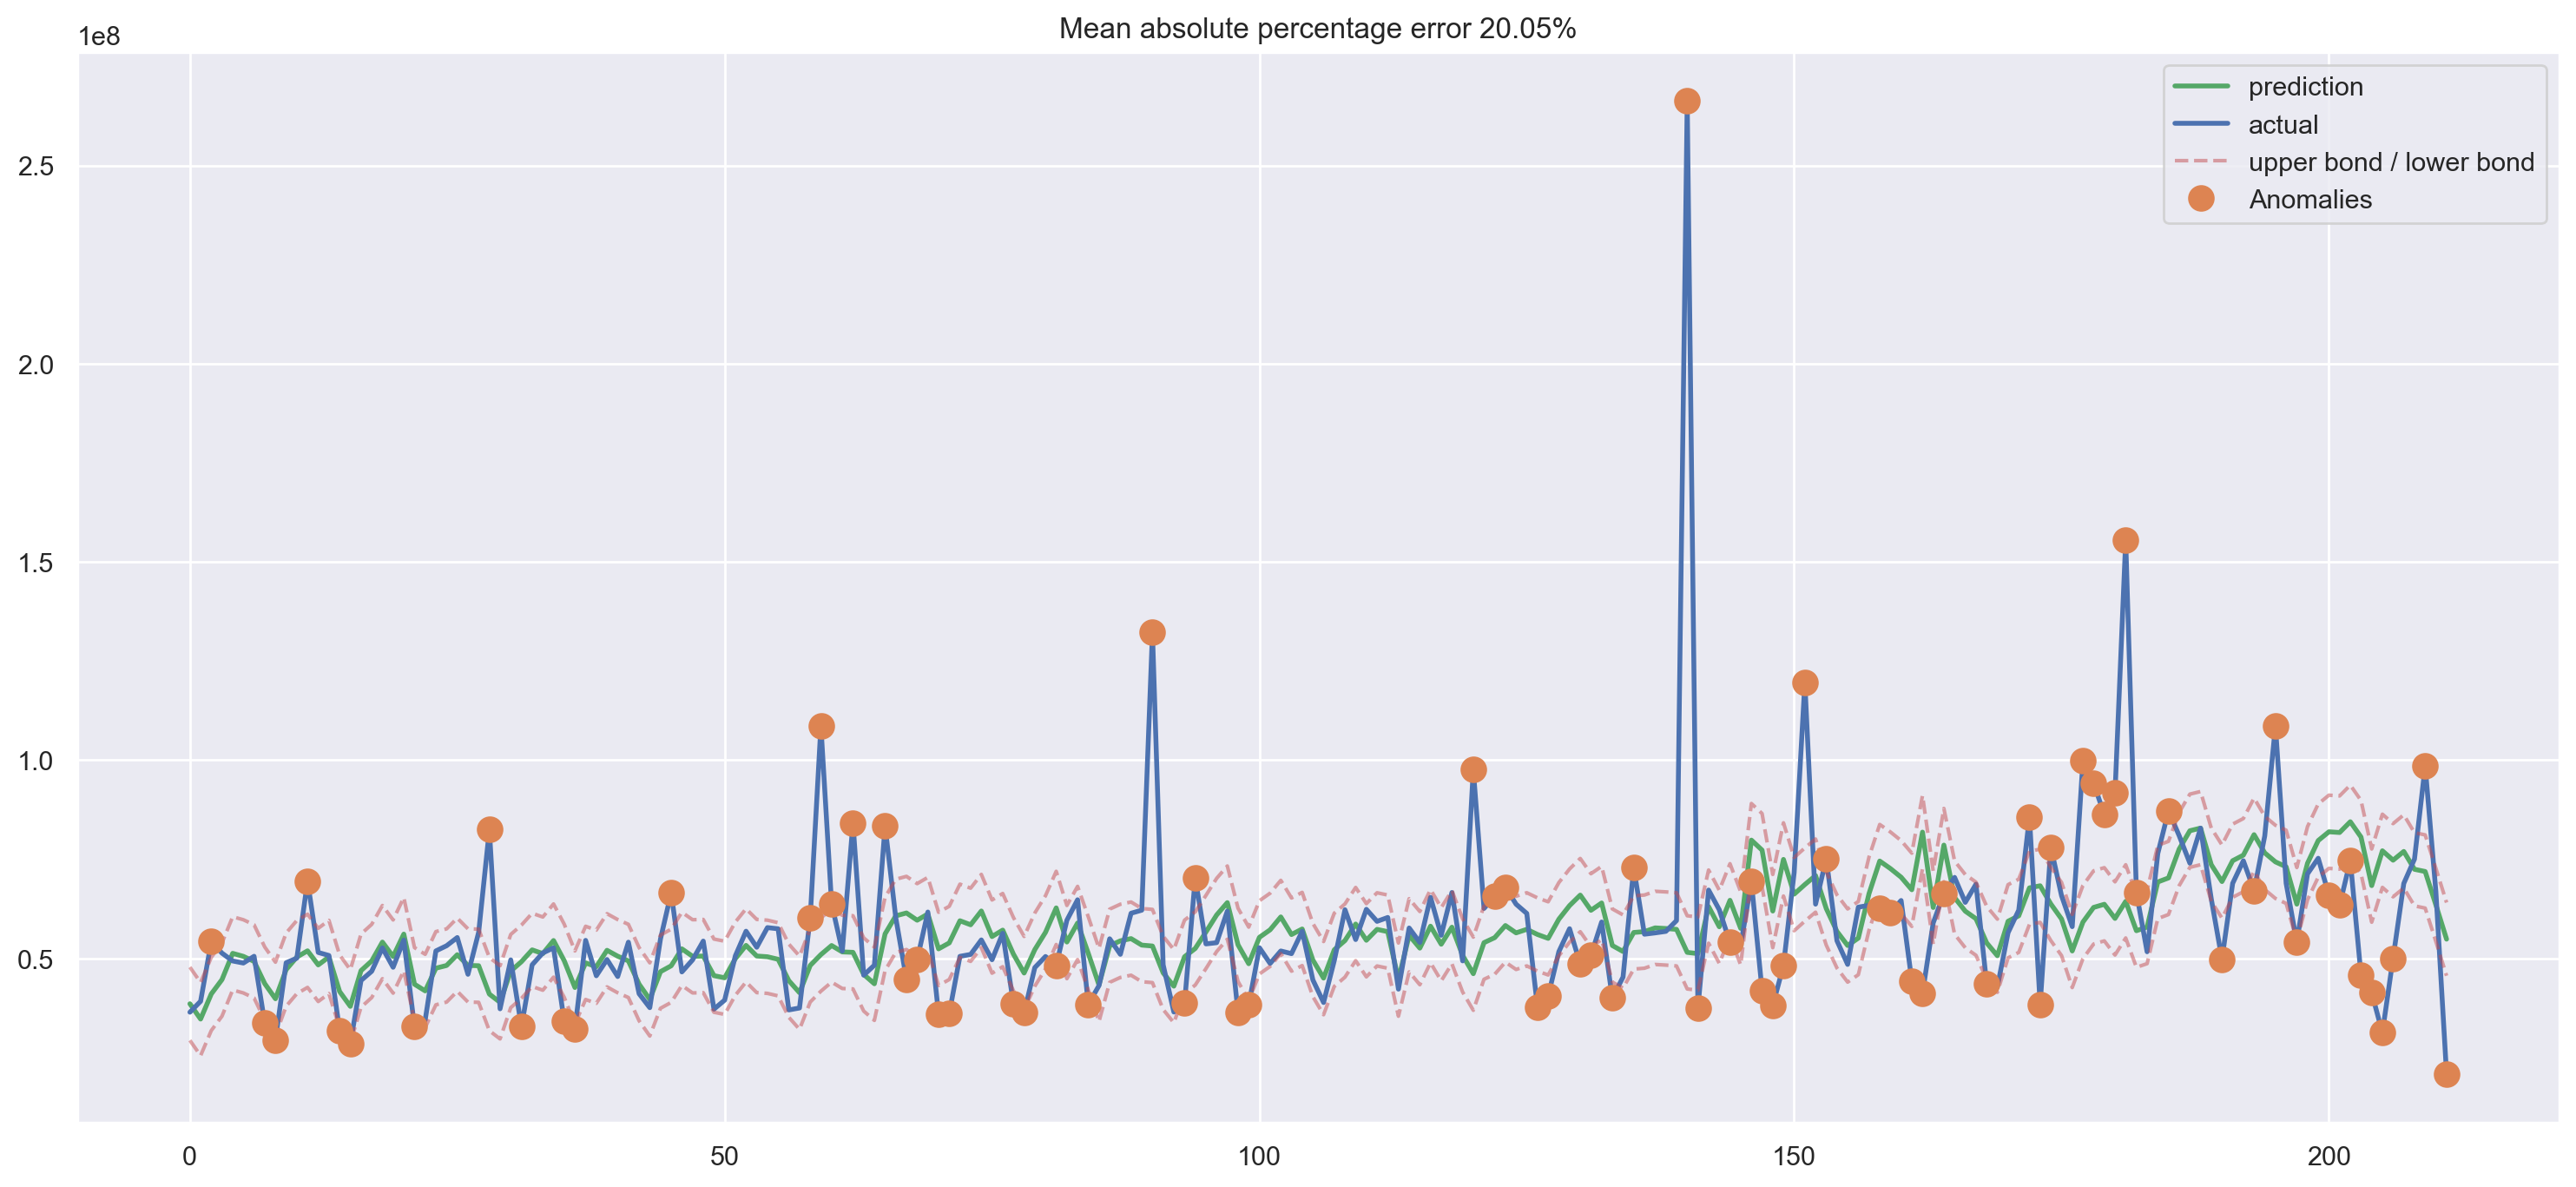

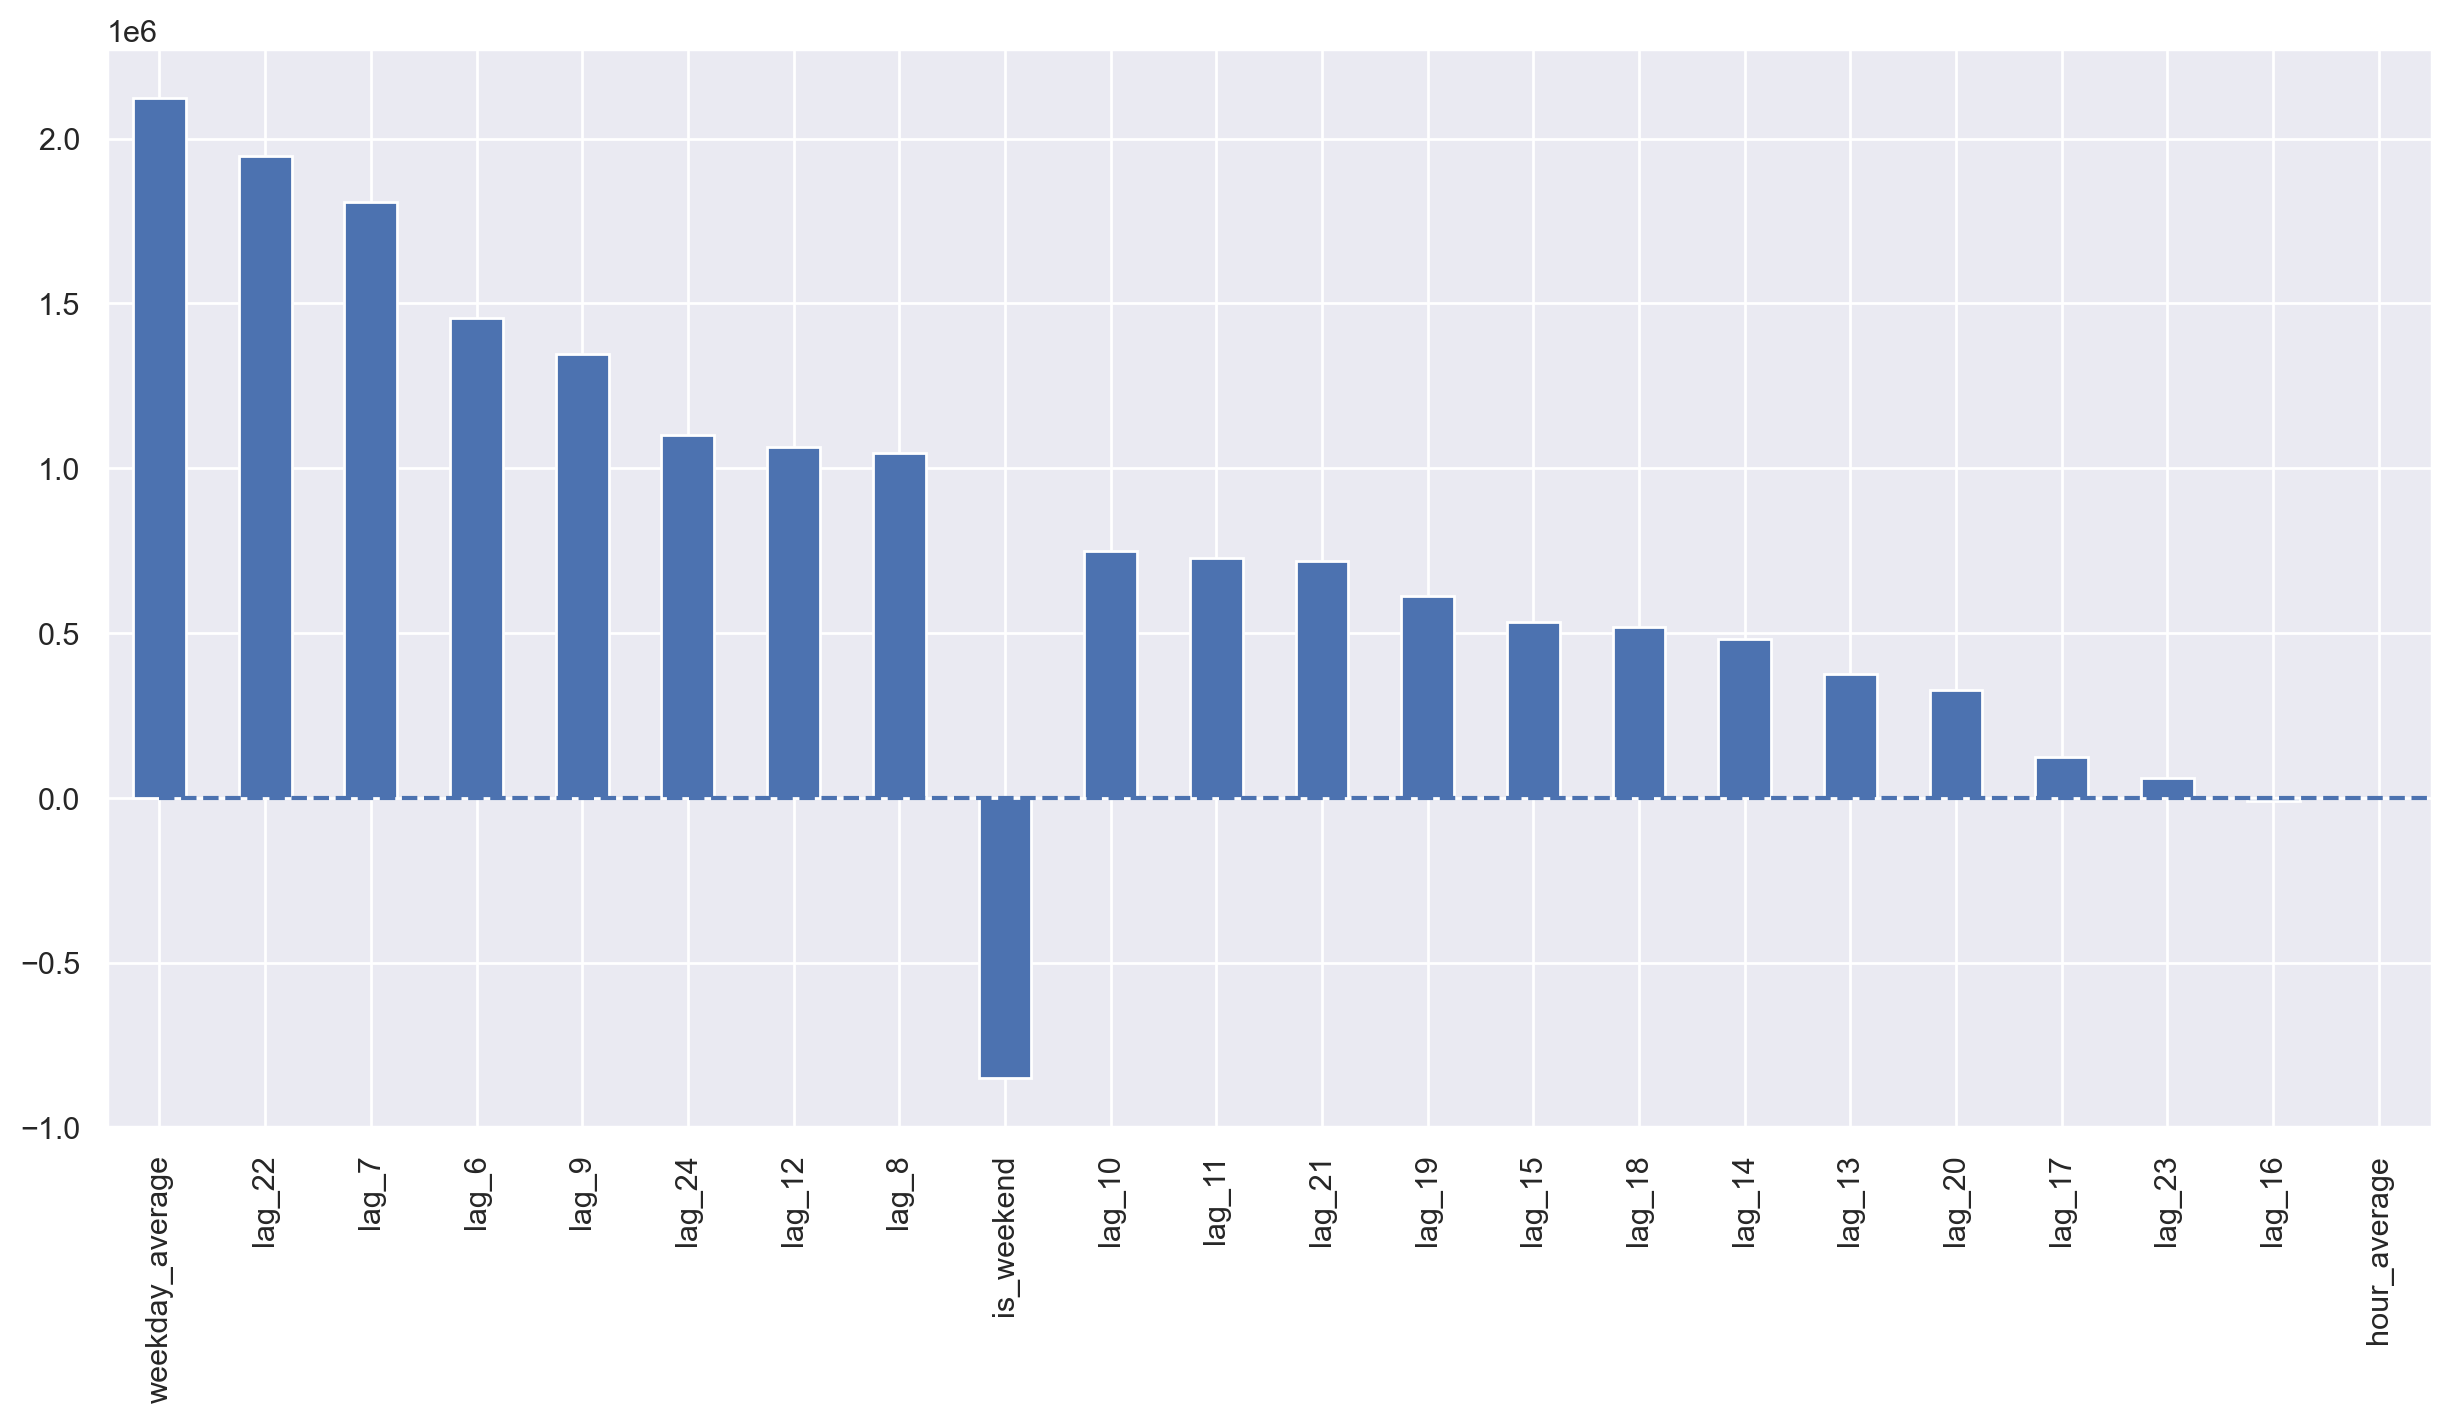

In [172]:
X_train, X_test, y_train, y_test = prepareData(
    series, lag_start=6, lag_end=25, test_size=0.3, target_encoding=True
)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(
    lr,
    X_train=X_train_scaled,
    X_test=X_test_scaled,
    plot_intervals=True,
    plot_anomalies=True,
)
plotCoefficients(lr)

In [190]:
# Installing Prophet
!conda install fbprophet
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats

%matplotlib inline

Retrieving notices: ...working... done



CondaHTTPError: HTTP 000 CONNECTION FAILED for url <https://repo.anaconda.com/pkgs/main/win-64/current_repodata.json>
Elapsed: -

An HTTP error occurred when trying to retrieve this URL.
HTTP errors are often intermittent, and a simple retry will get you on your way.

If your current network has https://repo.anaconda.com blocked, please file
a support request with your network engineering team.

'https//repo.anaconda.com/pkgs/main/win-64'




In [193]:
# Filter data for the desired period (2033-01-01 to 2035-01-01)
df = df[(df.index >= "2033-01-01") & (df.index < "2035-01-01")].sort_values(by=['time'])

In [195]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1513719 entries, 2033-01-01 09:38:32 to 2034-12-31 07:59:40
Data columns (total 3 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   Unnamed: 0           1513719 non-null  int64 
 1   merchant             1513719 non-null  object
 2   amount_usd_in_cents  1513719 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 46.2+ MB


In [ ]:
from plotly import graph_objs as go
from plotly.offline import init_notebook_mode, iplot

# Initialize plotly
init_notebook_mode(connected=True)

In [199]:
#As we are going to predict the number of amount_usd_in_cents, we will aggregate and
# count unique amount_usd_in_cents at each given point in time.
# We will name the corresponding new column `posts`:

aggr_df = df.groupby("time")[["merchant"]].count()
aggr_df.columns = ["amount_usd_in_cents"]
aggr_df.head()

,amount_usd_in_cents
time,
2033-01-01 09:38:32,1
2033-01-01 12:53:52,1
2033-01-01 15:08:55,1
2033-01-01 15:16:32,1
2033-01-01 15:19:16,1


In [189]:
import logging

from prophet import Prophet

logging.getLogger().setLevel(logging.ERROR)

'C:\\Users\\1126692\\Desktop\\Desktop Files\\Papers\\GWU PhD\\Python Lectures\\Lecture8'

In [ ]:
df = daily_df.reset_index()
df.columns = ["ds", "y"]
# converting timezones (issue https://github.com/facebook/prophet/issues/831)
df["ds"] = df["ds"].dt.tz_convert(None)
df.tail(n=3)

In [43]:

import pandas as pd
!pip install prophet
from prophet import Prophet

# Load daily_transactions data
data = data = pd.read_csv('daily_transactions.csv') 

# Prepare data in the format required by Prophet
df_prophet = pd.DataFrame({"ds": data.index, "y": data["amount"]})  # Assume "amount" is your transaction column

# Create and fit the Prophet model
model = Prophet()  # Optionally specify seasonalities or changepoints 
model.fit(df_prophet)

# Define the period for which we want a forecast
future_dates = pd.date_range(start=df_prophet.ds.max(), periods=30, freq="D") 
forecast_df = model.make_future_dataframe(periods=len(future_dates)) 

# Generate the forecast
forecast = model.predict(forecast_df)

# Plot the results
fig = model.plot(forecast)
fig.set_size_inches(12, 6)
plt.xlabel("Date")
plt.ylabel("Transactions")
plt.title("Prophet Forecast")
plt.show()

# (Optional) Plot components of the forecast 
fig2 = model.plot_components(forecast)

ERROR: Could not find a version that satisfies the requirement prophet (from versions: none)
ERROR: No matching distribution found for prophet


ModuleNotFoundError: No module named 'prophet'